# Evaluation of postprocessing approaches

## Prelude
In general, nuclei instance segmentation can be formulated as a classification or a regression problem. Hence, the model's objective is to learn a segmentation mask or a distance map for the classification and regression problem, respectively. In a segmentation mask, each pixel is assigned to a certain class. Such a class might be background, nucleus, nucleus center or nucleus border. In a binary segmentation mask, each pixel represents the probability of the pixel belonging to one of the two classes (e.g., nucleus vs. background). In a distance map, each pixel stats the minimal distance between the pixel and a pixel of a certain class (i.e., commonly the background). The chessboard distance is usually used as distance measure. However, other distance measures like the Manhattan or Euclidian distance could be used as well. Moreover, the distance might be isotropically or anisotropically (i.e., in a certain direction) calculated and the distance map normalized. The manigfold design choices for indiviual and the combination of multiple segmentation masks and/or distances maps give rise to diverse postprocessing strategies.

## Aim
Here, a qualitative and quantitative evaluation of the following postprocessing approaches is presented:
- Contour based
- Yang et al. 2006
- Naylor et al. 2019
- Graham et al. 2019
- Modified version of Graham et al. 2019


Furthermore, the postprocessing approaches are compared against a baseline approach incapable of separating touching/overlapping nuclei to allow for a better performance evaluation of the different postprocesing approaches. 

In [1]:
from typing import Any, Dict, List, Literal, Optional, overload, Tuple, Union
import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torchmetrics import MetricCollection
from tqdm import tqdm
import optuna
from optuna.samplers import TPESampler
import pandas as pd
from pandas import DataFrame
from pandas.io.formats.style import Styler
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from data.MoNuSeg.dataset import MoNuSeg
from data.MoNuSeg.data_module import MoNuSegDataModule
from data.MoNuSeg.conversion import NucleiInstances
from data.MoNuSeg.illustrator import Picture
from data.MoNuSeg.utils import custom_collate
from postprocessing.postprocesses import SegPostProcess, DistPostProcess, HVPostProcess
from evaluation.metrics import DSC, ModAJI, PQ
from tuning_postprocessing_parameters import suggest_thresh

/home/ubuntu/NucInstSeg/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_module = MoNuSegDataModule(
    seg_masks=True,
    cont_masks=True,
    dist_maps=True,
    hv_maps=True,
    labels=True,
    train_transforms=None,
    batch_size=16,
    data_root="datasets"
)
data_module.setup(stage=None)
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

data_module = MoNuSegDataModule(
    seg_masks=True,
    cont_masks=True,
    dist_maps=True,
    hv_maps=True,
    labels=True,
    train_transforms=None,
    batch_size=32,
    data_root="datasets"
)
data_module.setup(stage="test")
test_loader = data_module.test_dataloader()

In [3]:
lookup = {
    "TCGA-E2-A1B5-01Z-00-DX1": "Breast",
    "TCGA-E2-A14V-01Z-00-DX1": "Breast",
    "TCGA-A7-A13E-01Z-00-DX1": "Breast",
    "TCGA-B0-5698-01Z-00-DX1": "Kidney",
    "TCGA-B0-5710-01Z-00-DX1": "Kidney",
    "TCGA-B0-5711-01Z-00-DX1": "Kidney",
    "TCGA-21-5784-01Z-00-DX1": "Liver",
    "TCGA-21-5786-01Z-00-DX1": "Liver",
    "TCGA-38-6178-01Z-00-DX1": "Liver",
    "TCGA-CH-5767-01Z-00-DX1": "Prostate",
    "TCGA-G9-6362-01Z-00-DX1": "Prostate",
    "TCGA-G9-6356-01Z-00-DX1": "Prostate",
    "TCGA-DK-A2I6-01A-01-TS1": "Bladder",
    "TCGA-G2-A2EK-01A-02-TSB": "Bladder",
    "TCGA-AY-A8YK-01A-01-TS1": "Colon",
    "TCGA-NH-A8F7-01A-01-TS1": "Colon",
    "TCGA-KB-A93J-01A-01-TS1": "Stomach",
    "TCGA-RD-A8N9-01A-01-TS1": "Stomach"
}

In [4]:
default_pprocess_params = {
        "baseline": { 
            "min_obj_size": 0,
            "thresh_seg": None
            
        },
        "contour": {
            "min_obj_size": 0,
            "min_marker_size": 65,
            "thresh_seg": None,
            "thresh_cont": None
        },
        "yang": {
            "min_obj_size": 0,
            "thresh_seg": None,
            "thresh_coarse": 420,
            "thresh_fine": 350
        },
        "naylor": {
            "thresh_dist": "triangle",  # None
            "h_param": 1
        },
        "graham": {
            "min_obj_size": 0,
            "min_marker_size": 10,
            "thresh_seg": None,
            "thresh_comb": 0.55
        },
        "exprmtl": {
            "min_obj_size": 0,
            "min_marker_size": 0,
            "thresh_seg": None,
            "thresh_comb": "mean"
        }
    }

In [34]:
def make_pretty_tabel_performance(performance, caption: str) -> Styler:
    df = pd.DataFrame(performance)
    df = df.astype(float)
    df *= 100
    df.index += " [%]"
    styler = df.style
    styler.set_caption(caption)
    styler.format_index(str.title, axis=1)
    styler.format(precision=2)
    styler.highlight_max(axis=1, props="font-weight:bold")
    styler.set_table_styles([{'selector': 'caption', 'props': [ ('color', 'black'), ('text-align', 'center'), ('font-weight', 'bold')]}])
    return styler

def make_pretty_tabel_performance_score(performance, caption: str) -> Styler:
    df = pd.DataFrame(performance)
    df = df.astype(float)
    df *= 100
    df.loc["Mean [%]"] = df.mean()
    df.loc["Std [%]"] = df.std()
    styler = df.style
    styler.set_caption(caption)
    styler.format_index(str.title, axis=1)
    styler.format(precision=2)
    styler.highlight_max(axis=1, props="font-weight:bold")
    styler.set_table_styles([{'selector': 'caption', 'props': [ ('color', 'black'), ('text-align', 'center'), ('font-weight', 'bold')]}])
    return styler

In [6]:
def cal_performance_for_score(performance: dict, score: str="PQ") -> dict:
    performance_for_score = {}
    for m in performance:
        performance_for_score[m] = {organ: performance[m][organ][score] for organ in performance[m]}
    return performance_for_score

In [39]:
def make_performance_boxplot(performance: dict, score: str="PQ") -> None:
    performance = pd.DataFrame(performance)
    performance = performance.astype(float)
    performance *= 100
    performance.rename(columns=lambda x: x.title(), inplace=True)
    performance = performance.reset_index(names="Organ")
    performance = pd.melt(performance, id_vars=["Organ"], var_name="Methode", value_name="Score")
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    plt.figure(figsize=(6, 4.5))

    sns.boxplot(data=performance, x="Methode", y="Score", color="lightgray", width=0.4)
    sns.stripplot(data=performance,x="Methode", y="Score", hue="Organ", jitter=True, palette=sns.color_palette())

    
#     plt.title(score)
    plt.xlabel("Postprocessing method")
    plt.ylabel(f"{score} [%]")
    plt.xticks(rotation=45)
    plt.show()

In [8]:
@overload
def postprocess_gt(reduction: None) -> Dict[str, Tensor]: ...
@overload 
def postprocess_gt(reduction: Literal["organwise", "labelwise"]) -> Dict[str, Dict[str, Tensor]]: ...
def postprocess_gt(mode: str, pprocess_params: Dict[str, Any], dataloader: DataLoader, lookup: Dict[str, str], reduction: Optional[str]=None) -> Union[Dict[str, Tensor], Dict[str, Dict[str, Tensor]]]:
    postprocesses = {
        "baseline": SegPostProcess(mode="baseline", actv=False, seg_params=pprocess_params),
        "contour": SegPostProcess(mode="contour", actv=False, seg_params=pprocess_params),
        "yang": SegPostProcess(mode="yang", actv=False, seg_params=pprocess_params),
        "naylor": DistPostProcess(dist_params=pprocess_params),
        "graham": HVPostProcess(exprmtl=False, actv=False, hv_params=pprocess_params),
        "exprmtl": HVPostProcess(exprmtl=True, actv=False, hv_params=pprocess_params)
    }
    pprocess = postprocesses.get(mode)
    
    
    metrics = MetricCollection([
        DSC(),
        ModAJI(),
        PQ()
    ], compute_groups=False)
    
    performance = {}
    for batch_idx, gt in enumerate(dataloader):
        pred_inst = pprocess(gt)
        if reduction is None: 
            metrics.update(pred_inst, gt["inst"])
        elif reduction == "labelwise":  # Requires batch_size = 1
            label = gt["label"]
            performance[label] = metrics(pred_inst, gt["inst"])
            metrics.reset()
        elif reduction == "organwise":
            label = gt["label"]
            organ = set(lookup[l[:23]] for l in label)
            if len(organ) > 1:
                raise ValueError(f"Batch should only contain images from a single organ. Got instead {organ}.")
            organ = next(iter(organ))
            performance[organ] = metrics(pred_inst, gt["inst"])
            metrics.reset()
        else:
            raise ValueError(f"Reduction should be None, 'labelwise' or 'organwise'. Got instead {reduction}.")
            
    return metrics.compute() if reduction is None else performance

In [20]:
def rename(performance):
    prfrmnc = {}
    if "baseline" in performance:
         prfrmnc["baseline"] = performance["baseline"]
    if "contour" in performance:
         prfrmnc["contour"] = performance["contour"]
    if "yang" in performance:
         prfrmnc["yang"] = performance["yang"]
    if "naylor" in performance:
         prfrmnc["naylor"] = performance["naylor"]
    if "graham" in performance:
         prfrmnc["graham"] = performance["graham"]
    if "exprmtl" in performance:
         prfrmnc["mod. graham"] = performance["exprmtl"]
    return prfrmnc

In [10]:
class PostProcessParamsTuner:
    
    def __init__(self, mode: str, default_params: dict, dataloader: DataLoader, lookup: Dict[str, str], objective: str="PQ", direction: str="maximize", n_trials: Optional[int]=None, seed: int=40):
        if not self.is_tuneable(mode):
            raise ValueError(f"Mode should be 'contour', 'yang', 'naylor', 'graham', 'exprmtl'. Got instead {self.mode}")
        self.mode = mode
        self.default_params = default_params
        self.dataloader = dataloader
        self.lookup
        self.objective = objective
        self.direction = direction
        if n_trials is None:
            if self.mode == "contour":
                self.n_trials = 10
            elif self.mode == "yang":
                self.n_trials = 40
            elif self.mode == "naylor":
                self.n_trials = 60
            elif mode in ["graham", "exprmtl"]:
                self.n_trials = 60       
        elif isinstance(n_trials, int):
            self.n_trials = n_trials
        else:
            raise TypeError(f"Number of trials should be of type None or int. Got instead {type(n_trials)}.")
        self.seed = seed
    
    def __call__(self) -> dict:
        sampler = TPESampler(seed=self.seed)
        study = optuna.create_study(sampler=sampler, direction=self.direction)
        study.optimize(self.pparms_trial, n_trials=self.n_trials)
        return {**self.default_params, **study.best_trial.params}
    
    def pparms_trial(self, trial) -> Tensor:
        pprocess_params = {**self.default_params, **self.suggest_pprocess_params(trial, mode=self.mode)}
        scores = postprocess_gt(mode=self.mode, pprocess_params=pprocess_params, lookup=self.lookup, dataloader=self.dataloader, reduction=None)
        return scores[self.objective]
    
    @staticmethod
    def is_tuneable(mode: str):
        return mode in ["contour", "yang", "naylor", "graham", "exprmtl"]
    
    @staticmethod
    def suggest_pprocess_params(trial, mode: str) -> dict:

        if mode == "contour":
            pprocess_params = {
                "min_marker_size": trial.suggest_int("min_marker_size", 0, 80, step=5)
            }
            

        elif mode == "yang":
            thresh_coarse = trial.suggest_int("thresh_coarse", 0, 500, step=10)
            thresh_fine = trial.suggest_int("thresh_fine", 0, thresh_coarse, step=10)
            pprocess_params = {
                "thresh_coarse": thresh_coarse,
                "thresh_fine": thresh_fine
            }

        elif mode == "naylor":
            pprocess_params = {
                "h_param": trial.suggest_int("h_param", 0, 5, step=1),
                "thresh_dist": suggest_thresh(trial, thresh_name="thresh_dist", range_float=(0.3, 1.8), is_float=True)
            }

        elif mode in ["graham", "exprmtl"]:
            pprocess_params = {
                "thresh_comb": suggest_thresh(trial, thresh_name="thresh_comb", range_float=(0.3, 0.7)),
                "min_marker_size": trial.suggest_int("min_marker_size", 0, 80, step=5)
            }

        return pprocess_params

In [11]:
def eval_pprocesses(lookup: Dict[str, str], modes: Optional[List[str]]=None, tune_pprocess_params: bool=True, default_pprocess_params=default_pprocess_params): 
    if modes is None:
        modes = ["baseline", "contour", "yang", "naylor", "graham", "exprmtl"]
   
    val_performance, val_performance_organ, test_performance, test_performance_organ, pprocess_params = {}, {}, {}, {}, {}
    for mode in modes:
        print(f"###################### {mode.capitalize()} ######################")
        if tune_pprocess_params and PostProcessParamsTuner.is_tuneable(mode):
            print(f"Tuning postprocessing parameters for mode '{mode}' on valiation dataset.")
            pprocess_params[mode] = PostProcessParamsTuner(mode=mode, lookup=lookup, default_params=default_pprocess_params[mode], dataloader=val_loader, n_trials=None)()
        else:
            print(f"Loading default postprocessing parameters for mode '{mode}'.")
            pprocess_params[mode] = default_pprocess_params[mode]
        print(f"Calculating overall postprocessing performance for mode '{mode}' on validation dataset.")
        val_performance[mode] = postprocess_gt(mode=mode, lookup=lookup, dataloader=val_loader, pprocess_params=pprocess_params[mode], reduction=None)
        print(f"Calculating organwise postprocessing performance for mode '{mode}' on validation dataset.")
        val_performance_organ[mode] = postprocess_gt(mode=mode, lookup=lookup, dataloader=val_loader, pprocess_params=pprocess_params[mode], reduction="organwise")         
        print(f"Calculating overall postprocessing performance for mode '{mode}' on test dataset.")
        test_performance[mode] = postprocess_gt(mode=mode, lookup=lookup, dataloader=test_loader, pprocess_params=pprocess_params[mode], reduction=None)
        print(f"Calculating organwise postprocessing performance for mode '{mode}' on test dataset.")
        test_performance_organ[mode] = postprocess_gt(mode=mode, lookup=lookup, dataloader=test_loader, pprocess_params=pprocess_params[mode], reduction="organwise")
    
    return rename(val_performance), rename(val_performance_organ), rename(test_performance), rename(test_performance_organ), rename(pprocess_params)

In [21]:
val_performance, val_performance_organ, test_performance, test_performance_organ, pprocess_params = eval_pprocesses(modes=None, tune_pprocess_params=False, lookup=lookup)

###################### Baseline ######################
Loading default postprocessing parameters for mode 'baseline'.
Calculating overall postprocessing performance for mode 'baseline' on validation dataset.
Calculating organwise postprocessing performance for mode 'baseline' on validation dataset.
Calculating overall postprocessing performance for mode 'baseline' on test dataset.
Calculating organwise postprocessing performance for mode 'baseline' on test dataset.
###################### Noname ######################
Loading default postprocessing parameters for mode 'noname'.
Calculating overall postprocessing performance for mode 'noname' on validation dataset.
Calculating organwise postprocessing performance for mode 'noname' on validation dataset.
Calculating overall postprocessing performance for mode 'noname' on test dataset.
Calculating organwise postprocessing performance for mode 'noname' on test dataset.
###################### Yang ######################
Loading default postp

In [22]:
val_performance_c = val_performance.copy()
val_performance_organ_c = val_performance_organ.copy()
test_performance_c = test_performance.copy()
test_performance_organ_c = test_performance_organ.copy()
pprocess_params_c = pprocess_params.copy()

**Postprocessing parameters**

In [23]:
print(pprocess_params_c)

{'baseline': {'min_obj_size': 0, 'thresh_seg': None}, 'contour': {'min_obj_size': 0, 'min_marker_size': 65, 'thresh_seg': None, 'thresh_cont': None}, 'yang': {'min_obj_size': 0, 'thresh_seg': None, 'thresh_coarse': 420, 'thresh_fine': 350}, 'naylor': {'thresh_dist': 'triangle', 'h_param': 1}, 'graham': {'min_obj_size': 0, 'min_marker_size': 10, 'thresh_seg': None, 'thresh_comb': 0.55}, 'mod. graham': {'min_obj_size': 0, 'min_marker_size': 0, 'thresh_seg': None, 'thresh_comb': 'mean'}}


# 1. Quantitative  results

## 1.1 Overall performance on validation and test dataset

In [35]:
make_pretty_tabel_performance(val_performance_c, caption="Validation performance")

,Baseline,Contour,Yang,Naylor,Graham,Mod. Graham
DSC [%],100.00,100.00,100.00,99.47,99.93,100.00
ModAJI [%],85.07,96.75,90.19,97.03,96.43,97.05
DQ [%],94.98,98.45,95.85,98.50,97.49,99.16
SQ [%],96.49,98.23,96.97,97.68,98.52,98.47
PQ [%],91.65,96.71,92.95,96.22,96.05,97.65


In [36]:
make_pretty_tabel_performance(test_performance_c, caption="Test performance")

,Baseline,Contour,Yang,Naylor,Graham,Mod. Graham
DSC [%],100.00,100.00,100.00,99.49,99.95,100.00
ModAJI [%],79.16,98.41,89.49,97.30,97.40,98.43
DQ [%],91.24,98.56,94.48,98.82,98.12,99.54
SQ [%],96.15,98.93,96.75,98.05,98.83,98.96
PQ [%],87.73,97.50,91.42,96.90,96.97,98.50


In [33]:
"baseline".title()

'Baseline'

## 1.2 Oraganwise performance on test dataset

In [37]:
test_performance_pq = cal_performance_for_score(test_performance_organ_c, score="PQ")
make_pretty_tabel_performance_score(test_performance_pq, "Organwise PQ [%]")

,Baseline,Contour,Yang,Naylor,Graham,Mod. Graham
Breast,88.65,97.37,90.57,96.80,96.60,98.01
Kidney,91.26,97.46,94.18,97.91,97.98,98.85
Liver,78.02,94.76,86.29,94.52,94.06,96.99
Prostate,82.88,97.81,94.42,97.75,97.49,99.13
Bladder,91.62,98.39,94.67,98.04,96.94,99.01
Colon,94.92,99.11,88.84,95.78,97.78,99.36
Stomach,87.54,97.60,91.56,97.21,97.35,98.45
Mean [%],87.84,97.50,91.50,96.86,96.89,98.54
Std [%],5.32,1.26,2.95,1.20,1.23,0.76


/tmp/ipykernel_2154453/1369010159.py:13: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.stripplot(data=performance,x="Methode", y="Score", hue="Organ", jitter=True, palette=sns.color_palette())


<Figure size 800x600 with 0 Axes>

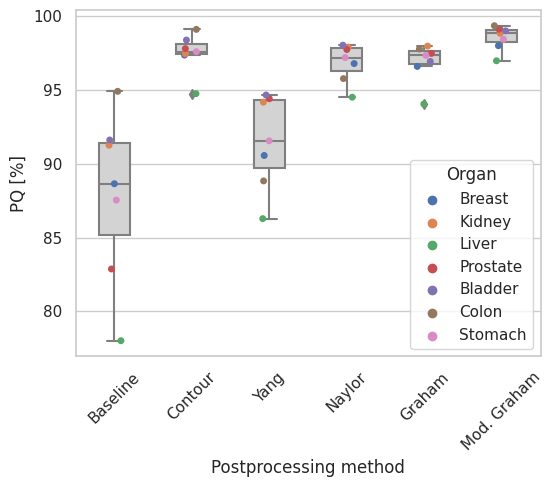

In [40]:
make_performance_boxplot(test_performance_pq)

In [41]:
test_performance_dq = cal_performance_for_score(test_performance_organ_c, score="DQ")
make_pretty_tabel_performance_score(test_performance_dq, "Organwise DQ [%]")

,Baseline,Contour,Yang,Naylor,Graham,Mod. Graham
Breast,91.82,98.75,93.77,99.31,98.10,99.44
Kidney,94.67,98.46,96.79,99.56,99.12,100.13
Liver,83.79,97.11,91.89,97.87,96.58,99.12
Prostate,86.89,98.33,96.36,99.15,98.28,99.72
Bladder,94.29,99.22,96.59,99.28,97.86,99.58
Colon,96.41,99.22,90.65,96.96,98.07,99.50
Stomach,91.21,98.69,95.02,99.15,98.39,99.49
Mean [%],91.30,98.54,94.44,98.76,98.06,99.57
Std [%],4.18,0.67,2.25,0.89,0.71,0.28


/tmp/ipykernel_2154453/1369010159.py:13: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.stripplot(data=performance,x="Methode", y="Score", hue="Organ", jitter=True, palette=sns.color_palette())


<Figure size 800x600 with 0 Axes>

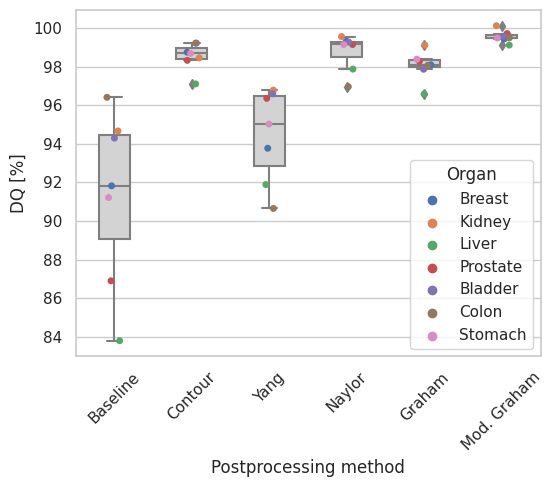

In [42]:
make_performance_boxplot(test_performance_dq, score="DQ")

In [43]:
test_performance_aji = cal_performance_for_score(test_performance_organ_c, score="ModAJI")
make_pretty_tabel_performance_score(test_performance_aji, "Organwise modified AJI [%]")

,Baseline,Contour,Yang,Naylor,Graham,Mod. Graham
Breast,82.79,98.42,88.89,97.87,97.45,98.10
Kidney,86.68,98.81,91.62,98.35,98.45,98.26
Liver,62.89,96.23,81.74,96.20,93.26,96.75
Prostate,70.56,99.24,94.25,98.22,97.93,99.23
Bladder,86.12,98.49,93.20,98.61,98.13,98.82
Colon,90.13,99.83,91.98,95.31,99.43,99.81
Stomach,80.27,97.97,87.40,97.76,97.37,97.92
Mean [%],79.92,98.43,89.87,97.47,97.43,98.41
Std [%],9.06,1.06,3.98,1.15,1.82,0.92


/tmp/ipykernel_2154453/1369010159.py:13: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.stripplot(data=performance,x="Methode", y="Score", hue="Organ", jitter=True, palette=sns.color_palette())


<Figure size 800x600 with 0 Axes>

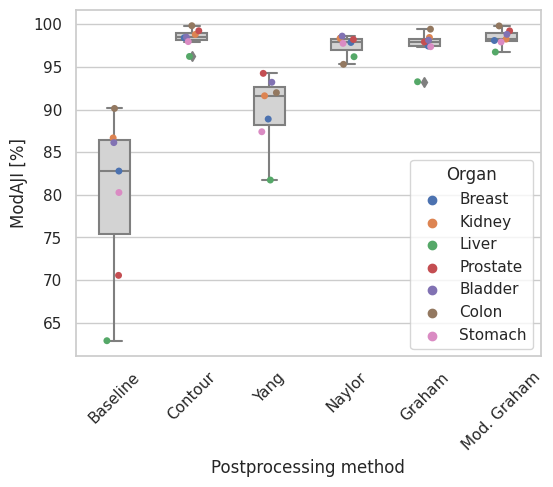

In [44]:
make_performance_boxplot(test_performance_aji, score="ModAJI")

In [45]:
test_performance_sq = cal_performance_for_score(test_performance_organ_c, score="SQ")
make_pretty_tabel_performance_score(test_performance_sq, "Organwise SQ [%]")

,Baseline,Contour,Yang,Naylor,Graham,Mod. Graham
Breast,96.55,98.60,96.59,97.47,98.47,98.56
Kidney,96.40,98.98,97.31,98.34,98.85,98.72
Liver,93.11,97.58,93.91,96.57,97.38,97.85
Prostate,95.38,99.47,97.98,98.59,99.19,99.41
Bladder,97.16,99.16,98.00,98.76,99.06,99.43
Colon,98.45,99.89,98.01,98.78,99.70,99.86
Stomach,95.98,98.90,96.36,98.04,98.95,98.95
Mean [%],96.15,98.94,96.88,98.08,98.80,98.97
Std [%],1.53,0.68,1.37,0.75,0.67,0.62


/tmp/ipykernel_2154453/1369010159.py:13: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.stripplot(data=performance,x="Methode", y="Score", hue="Organ", jitter=True, palette=sns.color_palette())


<Figure size 800x600 with 0 Axes>

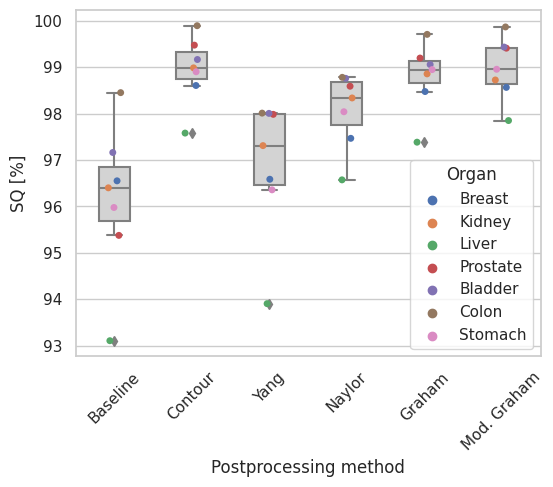

In [46]:
make_performance_boxplot(test_performance_sq, score="SQ")

# 2. Qualitative results

In [64]:
def show_pred_inst(pprocess_params: Dict[str, Any], modes: Optional[List[str]]=None, organ: str="liver", idx: int=0, show_title: bool=True) -> None:
    lookup = {
        "breast": "TCGA-E2-A1B5-01Z-00-DX1",
        "kidney": "TCGA-B0-5698-01Z-00-DX1",
        "liver": "TCGA-21-5784-01Z-00-DX1",
        "prostate": "TCGA-CH-5767-01Z-00-DX1",
        "bladder": "TCGA-DK-A2I6-01A-01-TS1",
        "colon": "TCGA-AY-A8YK-01A-01-TS1",
        "stomach": "TCGA-KB-A93J-01A-01-TS1"
    }
    label = lookup[organ]

    data = MoNuSeg(
        root="datasets",
        segmentation_masks=True,
        contour_masks=True,
        distance_maps=True,
        hv_distance_maps=True,
        labels=True,
        instances=True,
        dataset=[label],
        transforms=None,
        size="256"
    )
    loader = DataLoader(data, batch_size=16, shuffle=False, num_workers=torch.get_num_threads(), collate_fn=custom_collate)
    gt = next(iter(loader))
    if modes is None:
        modes = ["baseline", "contour", "yang", "naylor", "graham", "experimental"]
    postprocesses = {
        "baseline": SegPostProcess(mode="baseline", actv=False, seg_params=pprocess_params),
        "contour": SegPostProcess(mode="contour", actv=False, seg_params=pprocess_params),
        "yang": SegPostProcess(mode="yang", actv=False, seg_params=pprocess_params),
        "naylor": DistPostProcess(dist_params=pprocess_params),
        "graham": HVPostProcess(exprmtl=False, actv=False, hv_params=pprocess_params),
        "experimental": HVPostProcess(exprmtl=True, actv=False, hv_params=pprocess_params)
    }
    
    num_plots = len(modes) + 2
    plots_per_row = 4
    num_rows = -(num_plots // -plots_per_row)
    num_cols = num_plots if num_rows == 1 else plots_per_row
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.figure(figsize=(num_cols*4, num_rows*4))
    plt.subplot(num_rows, num_cols, 1)
    plt.imshow(Picture.from_tensor(gt["img"][idx]).data)
    plt.title("Image" if show_title else " ")
    plt.axis("off")
    
    plt.subplot(num_rows, num_cols, 2)
    plt.imshow(Picture.create_colored_inst(gt["inst"][idx]))
    plt.title("Ground truth" if show_title else " ")
    plt.axis("off")

    for position, mode in enumerate(modes, start=3):
        pprocess = postprocesses[mode]
        pred_inst = pprocess(gt)
        plt.subplot(num_rows, num_cols, position)
        plt.imshow(Picture.create_colored_inst(pred_inst[idx]))
        plt.title(mode.capitalize() if show_title else " ")    
        plt.axis("off")
    plt.tight_layout(pad=1.08 if show_title else 0)
    plt.show()

### Colon

<Figure size 640x480 with 0 Axes>

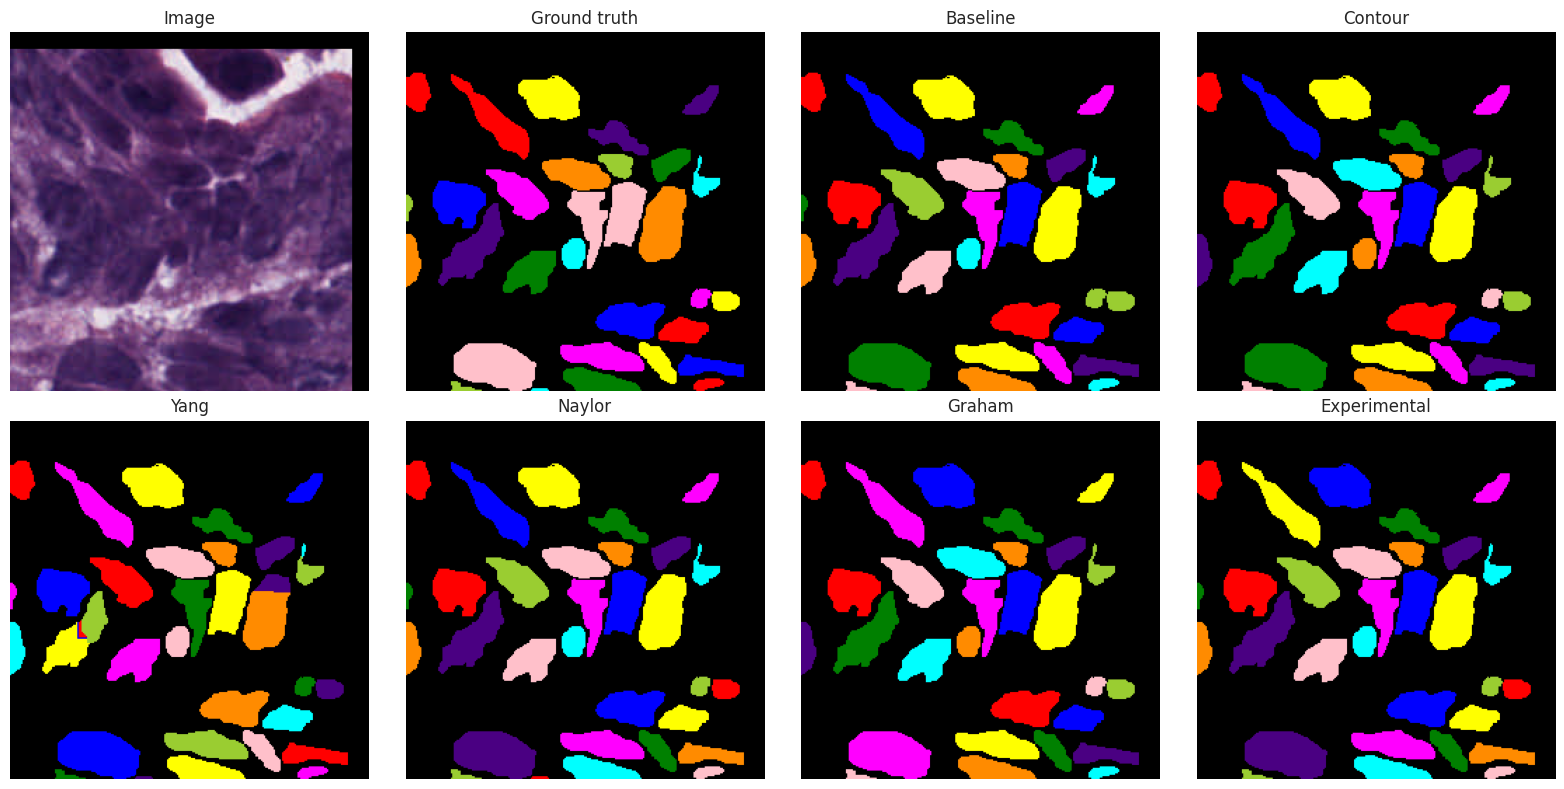

In [65]:
show_pred_inst(pprocess_params = default_pprocess_params, organ="colon", idx=3, show_title=True)

### Kidney

<Figure size 640x480 with 0 Axes>

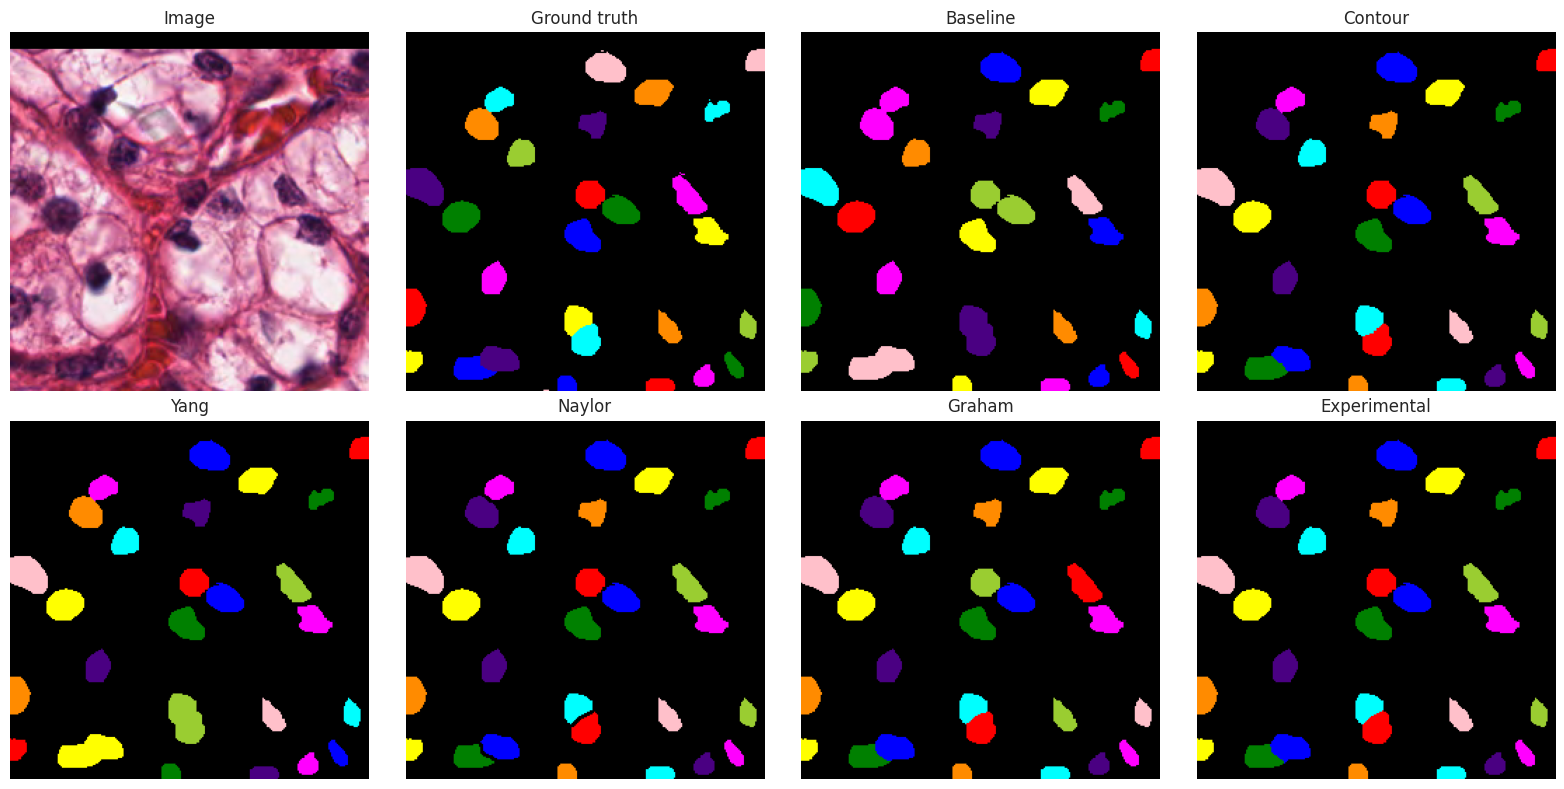

In [66]:
show_pred_inst(pprocess_params = default_pprocess_params, organ="kidney", idx=1, show_title=True)

### Liver

<Figure size 640x480 with 0 Axes>

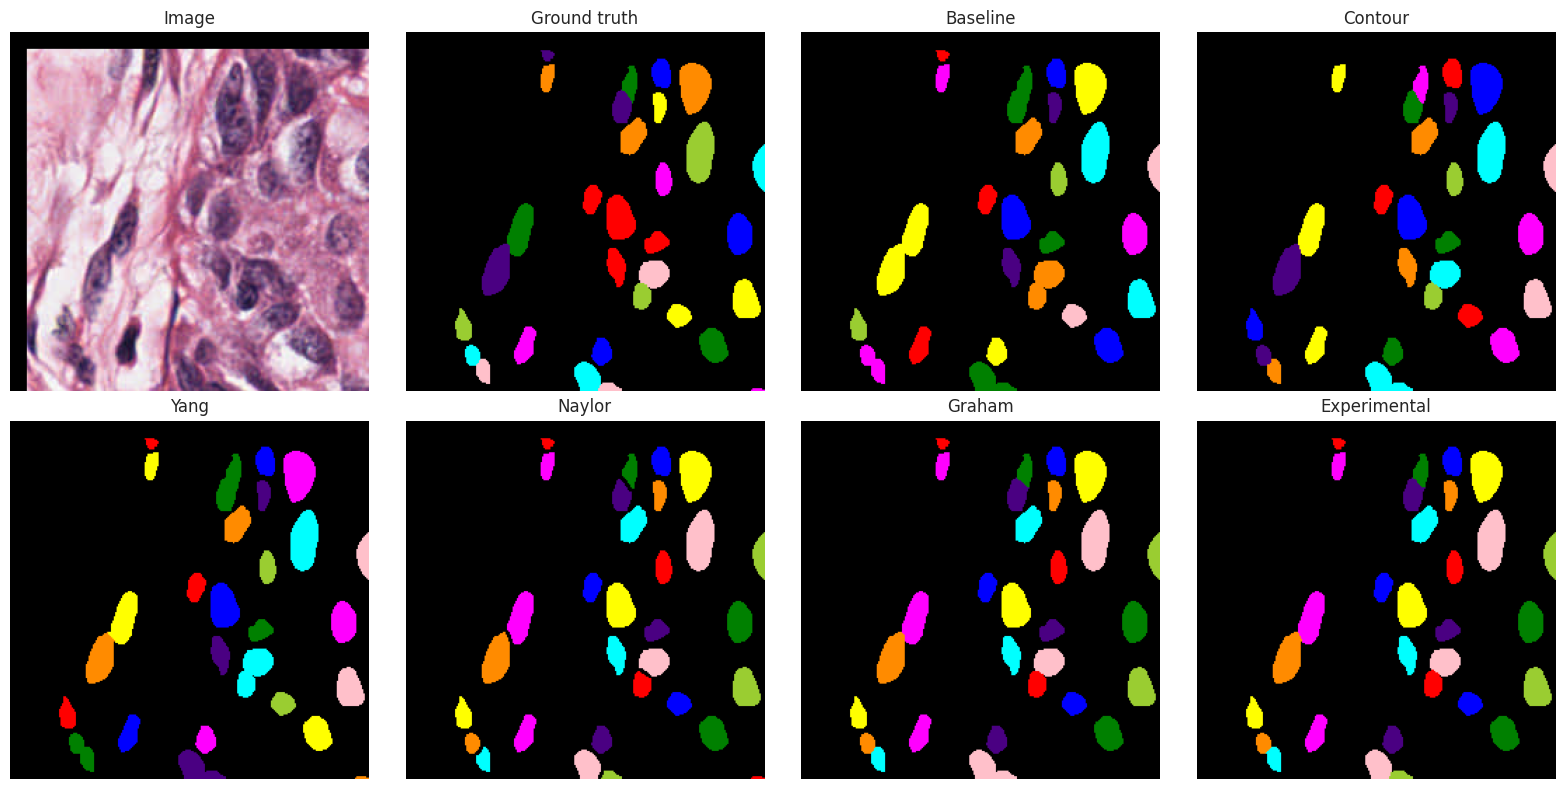

In [67]:
show_pred_inst(pprocess_params = default_pprocess_params, organ="liver", idx=0, show_title=True)